In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/words-to-train/words_250000_train.txt


Hangman Game (by Chinmay Routray) - My strategy

The idea was to train a RNN and obtain a model which can be later employed to play the game.

1- The first requirement is to prepare the training data from given words. The words in the given file have to be converted to obscure words with blanks 
'_' and their corresponding target labels and a list of wrong guesses. 

Target labels are list of all possible missing letters.

Wrong guesses is a list of randomly chosen letters in the complementary set of the given word or the letters which are absent in the word.
 
For example -     
                 (word) ----> (obscure word, label)                     (wrong guesses)

			      a n t ----> (a _ t , ['n'])                      (['e', 'i', 'u', 'p'])

		     p o t a t o ----> (p _ _ a _ _ , ['o', 't'])              (['e', 'i'])

2- How many '_' should be introduced ?
	Longest word length = 29
	Average word length = 9.4

I start by introducing one '_' replacing one letter in the word dataset. For each 200 epoch, no. of missing letters or '_' in its place is 
incremented by 1.
      Total no. of epochs = 3000

So that, by the end of training, we have training words with 15 missing letters (more than average). 
The training data is refreshed every 200 epochs and the difficulty level of the game increases as num of epochs increases.

If no. of '_' to be introduces > len(word), all letters are replaced by '_'. 

Ex -   a n t (drop 5 letters - 5 '_') ------> _ _ _  

3- How many words in wrong guess list ?
 
I designed the prob() function to find len(wrong guesses). The beginning of training has less missing letters or '_' and end of training has more.
So, beginning of training is equivalent to end of hangman game and end phase of training simulates beginning of hangman game.

In the beginning of game, wrong guess list is empty or has few letters, 
and in the end len(wrong guess) is more (close to allowed no. of attempts)

prob() given number in [1,5], 
len(wrong guess) = 1  in the beginning
len(wrong guess) = 5  in the end
max_misses = 5 as, if there are 6 misses the game ends


5- Next step is to encode obscure words, targets and wrong guesses.

We use a dictionary to map letters to indices.

0-26 for a-z and 27 for '_'

Obscure word - converted to a tensor of size (max_len x 27)
		   with 1s at indices of the letter present in corresponding position
              0s elsewhere

max_len = length of longest word
I used fixed padding, but word length is also kept so that, later it is passed to pack_padded_sequence(enforce_sorting = False) which would reduce
computations by packing the padded batch. 

For eg. - w = 'a b d' - size(29 x 27)
		w[0][0] = 1,  w[1][1] = 1, w[2][3] = 1, else w[x][y] = 0

targets - tensor of size (1 x 26)
          with 1s at indices present in label list, 0s elsewhere

wrong guess - tensor of size (1 x 26)
          with 1s at indices present in wrong guess list, 0s elsewhere


6- Next, step is choosing the batch size. I think there is a trade off between batch size and no. of batches when training dataset size is fixed.
In any case, I chose batch size = 4000

7- The model is a bi-directional LSTM. The idea is to give the encoded word as input, then extract the hidden_state from the LSTM, concatenate
it with the output of a linear layer whose input is encoded wrong guess. Then, pass this concatenated vector through a ReLU layer, then, again
a linear layer to get the prediction. Compare it with target labels. Model parameters are chosen conventionaly.

Loss function chosen is BCEwithLegits(reduction=sum) as each prediction vector element is either 0 or 1. (binary classification)

Optimizer is Adam() with learning rate = 0.0005
I tried with lr = 0.005 ----> not good
I think somewhere in (0.0009, 0.0005) would be best. I could not be sure as I had limited training trials.

8- The model is trained with GPU P100 on kaggle. 
The model is saved to a file after training completes.
In the guess_word() function, this trained model is loaded and provided with encoded inputs to output a (1 x 26) tensor.
The index with maximum value is mapped to its corresponding alphabet to return a letter.


In [58]:
# extract all words
filename = r"/kaggle/input/words-to-train/words_250000_train.txt"
t = []
with open(filename, 'r') as f:
    for line in f:
        if(len(line.strip('\n')) > 2):
            t.append(line.strip('\n'))

# t = sorted(t, key=len, reverse=True)
max_len = len(max(t, key=len))
a = [len(x) for x in t]
avg_len = sum(a)/len(a)
t[:5], max_len

(['aaa', 'aaaaaa', 'aaas', 'aachen', 'aaee'], 29)

In [59]:
import random
n_vocab = 26
extra = 1

char_idx = {chr(97+x) : x for x in range(n_vocab)}
all_chars = list(char_idx.keys())
char_idx['_'] = 26

In [60]:
import numpy as np
def prob(epoch_n, max_misses):
    z_min = 1 - (1/(1 + np.exp(-30/30)))
    z_max = 1 - (1/(1 + np.exp(-2/30)))

    z = (1 - 1/(1 + np.exp(-epoch_n/3000))) - z_min
    z = z/(z_max - z_min)*max_misses

    return round(z)

In [61]:
def create_hidden_word(word, drop_num, epoch):

    max_misses = 5
    if len(word) > 2:
        if len(word) > drop_num :
            # getting possible labels 
            drop_idx_mat = random.sample(range(len(word)), drop_num)
            targets = list(set([word[x] for x in drop_idx_mat]))
            


            # finding the wrongly guessed characters
            chars = list(word)
            not_present = sorted(list((set(all_chars)) - set(chars)))
            num_wrong_guess = prob(epoch, max_misses)
            wrong_guesses = random.sample(not_present, num_wrong_guess)

            # replacing with '_'
            for x in drop_idx_mat:
                word = word.replace(word[x], '_', 1)

            return (word, targets, wrong_guesses, len(word))
        
        else:
            # getting the labels
            targets = list(set([x for x in word]))

            # wrongly guessed characters
            not_present = sorted(list(set(all_chars) - set(list(word))))
            num_wrong_guess = prob(epoch, max_misses)
            wrong_guesses = random.sample(not_present, num_wrong_guess)

            # replacing all with '_'
            for x in set(list(word)):
                word = word.replace(x, '_')
   
            return (word, targets, wrong_guesses, torch.tensor(len(word), dtype = torch.int8))
    
    return (None, None, None)

In [62]:
import torch
def target_encoding(targets):
    vec = torch.zeros(1, n_vocab)
    for x in targets:
        vec[0][char_idx[x]] = 1 
    return vec

In [63]:
def wrong_guesses_encoding(wr_guess_list):
    vec = torch.zeros(1, n_vocab)
    if len(wr_guess_list) == 0:
        return vec
    for x in wr_guess_list:
        vec[0][char_idx[x]] = 1

    return vec


In [64]:
def hidden_word_encoding(word):
    mat = torch.zeros(max_len, n_vocab + extra)
    for i, ch in enumerate(word):
        mat[i][char_idx[ch]] = 1
        
    return mat

In [10]:
# def pad_with_max_len(batch, w_lens):
#     seq_len = len(batch)
#     max_l = max(w_lens)
#     final_batch = []
    
#     for word in batch:
#         if max_l != word.size[0]:
#             padding = torch.zeros(max_l - word.size[0], n_vocab + extra)
            
#             final_batch.aapend(torch.cat((word, padding), dim=0))
    
#     return torch.Tensor(final_batch)

In [65]:
class DataPreProcessing:
    
    def __init__(self, drop, epoch):
        # self.num = num
        self.drop_num = drop
        self.epoch = epoch

    def get_hidn_w_list(self):
        l = []
        for i in t:
            l.append(create_hidden_word(i, self.drop_num, self.epoch))
        return l
    
    def encode(self, l):
        input = []
        labels = []
        wrong_guesses = []
        w_lens = []

        for i in l:
            input.append(hidden_word_encoding(i[0]))
            labels.append(target_encoding(i[1]))
            wrong_guesses.append(wrong_guesses_encoding(i[2]))
            w_lens.append(i[3])
        
        return input, labels, wrong_guesses, w_lens

In [66]:
len(t)

227019

In [8]:
# setting the hyper-parameters

batch_size = 4000
num_epoch = 1000
lr = 0.0005
num_layers = 2
hidden_size = 512


In [68]:
from torch.utils.data import Dataset, DataLoader

class WordData(Dataset):

    def __init__(self, drop_num, epoch):
        
        data = DataPreProcessing(drop_num, epoch)
        input, labels, wrong_guesses, w_lens = data.encode(data.get_hidn_w_list())

        self.n_samples = len(input)
        self.hidden_words = input
        self.labels = labels
        self.wr_guess = wrong_guesses
        self.w_lens = torch.tensor(w_lens)

    def __getitem__(self, idx):
        return self.hidden_words[idx], self.labels[idx], self.wr_guess[idx], self.w_lens[idx]
    
    def __len__(self):
        return self.n_samples

Designing the Model to play Hangman

In [6]:
import torch.nn as nn

class RNN(nn.Module):

    def __init__(self):
        super(RNN, self).__init__()

        # for LSTM layer
        self.rnn_name = 'LSTM'
        self.input_dim = n_vocab + extra      # 27
        self.hidden_dim = hidden_size         # 512
        self.num_layers = num_layers          # 2
        self.output_dim = n_vocab             # 26

        # for linear layer after LSTM 
        in_features = 256 + self.hidden_dim*2      # 256 + 512*2 = 1280
        mid_features = 256

        self.linear1_out = nn.Linear(in_features, mid_features)
        self.relu = nn.ReLU()
        self.linear2_out = nn.Linear(mid_features, self.output_dim)

        self.miss_linear = nn.Linear(n_vocab, 256)

        # setting up the LSTM
        self.rnn = nn.LSTM(input_size = self.input_dim, hidden_size = self.hidden_dim, 
                           num_layers = self.num_layers, dropout = 0.3, bidirectional = True, 
                           batch_first = True)
        
    
    # forward propagation
    def forward(self, x_in, wr_guess, x_lens):

        batch, seq_len, input_size = x_in.size()
        # pack the padded sequence
        x = torch.nn.utils.rnn.pack_padded_sequence(x_in, x_lens, batch_first=True, enforce_sorted=False)

        # run through RNN and collect hidden state                            # x - (batch x max_len x 27)
        out, (hidden, c_n) = self.rnn(x)
        
        hidden = hidden.view(self.num_layers, 2, -1, self.hidden_dim)         # (2, 2, -1, 512)
        hidden = hidden[-1]

        hidden = hidden.permute(1, 0, 2)

        hidden = hidden.contiguous().view(hidden.shape[0], -1)

        # pass wrong guesses through miss_linear layer
        wr_guess = self.miss_linear(wr_guess).squeeze(1)                                 # wr_guess - (1 x 256)

        # print(hidden.shape, wr_guess.shape)
        # concatenate wrong guesses and hidden state
        concatenated = torch.cat((hidden, wr_guess), dim=1)

        # predict
        return self.linear2_out(self.relu(self.linear1_out(concatenated)))


In [70]:
# Initializations
device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
model = RNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
cost_f = nn.BCEWithLogitsLoss(reduction='sum')
device

'cuda'

Training the Model

In [71]:
# creating the data loader for the first time
train_ds = WordData(1, 1)
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, 
                      shuffle=True, num_workers=2)



In [72]:
print(len(train_dl))
next(iter(train_dl))[3]
# device
# p = batchify(w_in, w_lens)

57


tensor([11,  5,  6,  ...,  5,  8, 10])

In [73]:
import time
drop = 1
x = []
y = []
print('...Training starting...\n undergoing training...')
t1 = time.time()
for epoch in range(num_epoch):

    for i, (w_in, label, wr_guess, w_lens) in enumerate(train_dl):
        
        model.train()

        w_in = w_in.to(device)
        label = label.to(device)
        wr_guess = wr_guess.to(device)
        # w_lens = w_lens.to(device)

        # forward propagation
        prediction = model(w_in, wr_guess, w_lens)
        loss = cost_f(prediction, label.squeeze_(1))

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i + 1) % 40 == 0:
            # capturing the loss
            x.append(epoch+1)
            y.append(loss)

            print(f"Step / Epochs : {i+1}/{epoch+1}/{num_epoch},      loss : {loss}")



    if(epoch+1) % 100 == 0:
        drop += 1 
        # refresh the dataloader
        data = WordData(drop, epoch+1)                # -----------> design the workdata
        train_dl = DataLoader(dataset=data, batch_size = batch_size, 
                              shuffle = True, pin_memory=True, num_workers=2)
        
        print(f"Mark Epochs : {epoch+1}/{num_epoch},      loss : {loss}")
        
print("Training Complete...\n Saving the model...")

FILE = 'Hangman_player_trained_model.pth'

data = {
    'model_state' : model.state_dict()
}
torch.save(data, FILE)
print(f"Model parameters saved to {FILE}...")

# Recording the time 
t2 = time.time()
t = t2 - t1
print(f"Time taken for model training : {t}")



...Training starting...
 undergoing training...
Step / Epochs : 40/1/1000,      loss : 15749.3701171875
Step / Epochs : 40/2/1000,      loss : 15500.302734375
Step / Epochs : 40/3/1000,      loss : 15510.708984375
Step / Epochs : 40/4/1000,      loss : 15374.2265625
Step / Epochs : 40/5/1000,      loss : 15323.521484375
Step / Epochs : 40/6/1000,      loss : 15320.7783203125
Step / Epochs : 40/7/1000,      loss : 15233.9423828125
Step / Epochs : 40/8/1000,      loss : 15150.572265625
Step / Epochs : 40/9/1000,      loss : 15029.818359375
Step / Epochs : 40/10/1000,      loss : 14719.728515625
Step / Epochs : 40/11/1000,      loss : 13865.7509765625
Step / Epochs : 40/12/1000,      loss : 13411.556640625
Step / Epochs : 40/13/1000,      loss : 13012.5517578125
Step / Epochs : 40/14/1000,      loss : 12804.8017578125
Step / Epochs : 40/15/1000,      loss : 12556.5615234375
Step / Epochs : 40/16/1000,      loss : 12389.0712890625
Step / Epochs : 40/17/1000,      loss : 12084.6181640625
St

Displaying training results ... 


Text(0, 0.5, 'cost function')

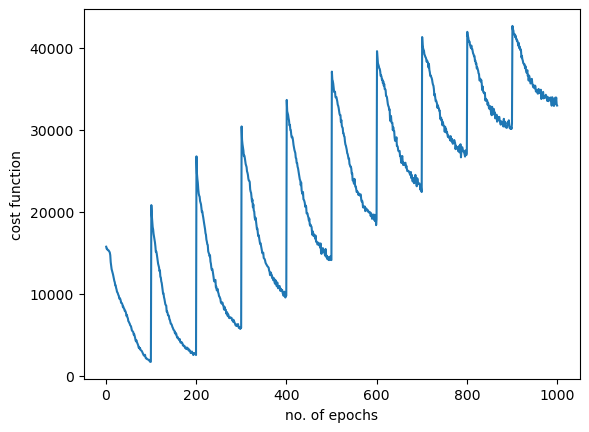

In [74]:
# Plotting loss vs no. of epochs
import matplotlib.pyplot as plt
print('Displaying training results ... ')
y = [i.item() for i in y]
plt.plot(x, y)
plt.xlabel('no. of epochs')
plt.ylabel('cost function')

In [53]:
y[0].item()

19762.3671875

This marks the end of Training code. Find below the implementation of guess() function which predicts the letter, given word and list of previous guesses.
The guess() fuction is integrated with hangman_api which plays the game.

In [ ]:
def guess(self, word, guess_list): # word input example: "_ p p _ e "
        
        # clean the word so that we strip away the space characters
        word = word.strip().replace(' ', '')
        
        # encoding the word
        encoded_word = torch.zeros(len(word), n_vocab + extra)
        for i, ch in enumerate(word):
            encoded_word[i][self.char_to_id[ch]] = 1
        
        encoded_word = encoded_word.unsqueeze(0)
        
        # encoding the guess_list
        vec = torch.zeros(1, n_vocab)
        if len(guess_list) > 0:
            for x in guess_list:
                vec[0][self.char_to_id[x]] = 1

        encoded_list = vec.unsqueeze(0)

        # loading the Trained model
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        data = torch.load(r"C:\Users\chinmay\Downloads\Hangman_player_trained_1000_epoch.pth", map_location=torch.device('cpu'))
        model_state = data['model_state']
        model = RNN().to(device)
        model.load_state_dict(model_state)

        # word length tensor
        w_len = torch.tensor([len(word)])

        # predicting
        pred = torch.argsort(torch.softmax(model(encoded_word, encoded_list, w_len), 1),-1, descending=True).squeeze(0)
        l = [self.id_to_char[x.item()] for x in pred]
        
        for p in l:
            if(p not in guess_list):
                return p

Limitations I faced - 

1- I could only train the model for 1000 epochs with training data refresing every 100 iterations and could introduce maximum of 10
'_' or missing letters while training, which took me 5.5 hours due to lack of computational infrastructure. Not to count other trial
runs. 

Recorded results are with a model trained upto 1000 epochs with a refreshed dataset after each 100 epoch, maximum 10 missing letters during training.

I believe if I were able to train the model for 3000 - 5000 epochs, my results would be better.
With better infrastructure, I believe the model could have been trained better. I could also get the chance to tune the hyper-parameters.


What could have been done better -

I think with more number of missing letters, there is a requirement of more training epochs to bring down loss, i.e. the training data
refresh rate should go down as the training progresses. For eg. at the start, training data refreshes every 200 epoch,
it should gradually refresh at 300 or 375(>200) epochs as training continues.